In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [2]:
def pt_module_parameters(module):
    """ Retorna la cantidad de parametros del modulo pytorch """
    pp=0
    for p in list(module.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

# Create dataset and dataloader
class CoordinateDataset(Dataset):
    def __init__(self, data_dir):
        self.data = pd.read_csv(data_dir)
        self.x, self.y = self.__processing()

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] # Se regresa un registro de datos junto con su etiqueta

    def __len__(self):
        return len(self.data)

    def __processing(self):
        i, o = self.data[['x', 'y']].to_numpy(), self.data[['z', 'r', 'g', 'b']].to_numpy()
        return torch.from_numpy(i).float(), torch.from_numpy(o).float()  
    
# Rotary Position Embedding (RoPE) module
class RoPE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        inv_freq = torch.logspace(0, 3, dim//2) #Valores que multiplican al angulo van desde 1 a 1000 en escala logaritmica
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x):
        # x shape: (batch_size, 2) containing (x, y) coordinates
        x_coords = x[:, 0]
        y_coords = x[:, 1]
        
        x_embed = self._embed_single(x_coords)
        y_embed = self._embed_single(y_coords)
        return torch.cat([x_embed, y_embed], dim=1)

    def _embed_single(self, pos):
        # pos shape: (batch_size,)
        angles = pos.unsqueeze(-1) * self.inv_freq.unsqueeze(0)
        sin = torch.sin(angles)
        cos = torch.cos(angles)
        
        # Interleave sin and cos values
        embed = torch.stack([sin, cos], dim=-1)
        return embed.view(embed.size(0), -1)
    
# Neural network architecture
class ColorNetRope(nn.Module):
    def __init__(self, rope_dim, linear_dim):
        super().__init__()
        self.rope = RoPE(rope_dim)
        self.layers = nn.Sequential(
            nn.Linear(2 * rope_dim, linear_dim),
            nn.GELU(), 
            nn.Linear(linear_dim, linear_dim),
            nn.GELU(),
            nn.Linear(linear_dim, linear_dim),
            nn.GELU(),
            nn.Linear(linear_dim, 4),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.rope(x)
        return self.layers(x)
    

In [5]:
# Configuration
EPOCHS = 100
BATCH_SIZE = 2048
LEARNING_RATE = 0.001
ROPE_DIM = 128   # Dimension for each coordinate's RoPE embedding
LINEAR_DIM = 256 # Dimension for each linear layer

POOL_NAME = 'RBN_zw_-100000000.0'
PROJECT_NAME = 'pozas_110125_100_10_120'
PATH_DATASET = f'data/{PROJECT_NAME}/{POOL_NAME}.csv'

In [6]:
dataset = CoordinateDataset(PATH_DATASET)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False) 

In [7]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = ColorNet().to(device)
model = ColorNetRope(ROPE_DIM, LINEAR_DIM).to(device)
criterion = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LEARNING_RATE*0.1)

print(f"Model Parameters: {pt_module_parameters(model)}")

Model Parameters: 198404


In [8]:
# Training loop
train_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=loss.item(), lr=scheduler.get_last_lr()[0])
    scheduler.step()
    epoch_loss /= len(dataset)
    train_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.6f} LR: {scheduler.get_last_lr()[0]:.6f}')

Epoch 1/100 - Loss: 0.002962 LR: 0.001000


Epoch 2/100 - Loss: 0.002215 LR: 0.000999


Epoch 3/100 - Loss: 0.002041 LR: 0.000998


Epoch 4/100 - Loss: 0.001952 LR: 0.000996


Epoch 5/100 - Loss: 0.001893 LR: 0.000994


Epoch 6/100 - Loss: 0.001853 LR: 0.000992


Epoch 7/100 - Loss: 0.001821 LR: 0.000989


Epoch 8/100 - Loss: 0.001801 LR: 0.000986


Epoch 9/100 - Loss: 0.001783 LR: 0.000982


Epoch 10/100 - Loss: 0.001764 LR: 0.000978


Epoch 11/100 - Loss: 0.001750 LR: 0.000973


Epoch 12/100 - Loss: 0.001738 LR: 0.000968


Epoch 13/100 - Loss: 0.001728 LR: 0.000963


Epoch 14/100 - Loss: 0.001719 LR: 0.000957


Epoch 15/100 - Loss: 0.001712 LR: 0.000951


Epoch 16/100 - Loss: 0.001702 LR: 0.000944


Epoch 17/100 - Loss: 0.001694 LR: 0.000937


Epoch 18/100 - Loss: 0.001687 LR: 0.000930


Epoch 19/100 - Loss: 0.001678 LR: 0.000922


Epoch 20/100 - Loss: 0.001671 LR: 0.000914


Epoch 21/100 - Loss: 0.001666 LR: 0.000906


Epoch 22/100 - Loss: 0.001660 LR: 0.000897


Epoch 23/100 - Loss: 0.001653 LR: 0.000888


Epoch 24/100 - Loss: 0.001645 LR: 0.000878


Epoch 25/100 - Loss: 0.001639 LR: 0.000868


Epoch 26/100 - Loss: 0.001634 LR: 0.000858


Epoch 27/100 - Loss: 0.001626 LR: 0.000848


Epoch 28/100 - Loss: 0.001620 LR: 0.000837


Epoch 29/100 - Loss: 0.001614 LR: 0.000826


Epoch 30/100 - Loss: 0.001610 LR: 0.000815


Epoch 31/100 - Loss: 0.001602 LR: 0.000803


Epoch 32/100 - Loss: 0.001595 LR: 0.000791


Epoch 33/100 - Loss: 0.001588 LR: 0.000779


Epoch 34/100 - Loss: 0.001579 LR: 0.000767


Epoch 35/100 - Loss: 0.001576 LR: 0.000754


Epoch 36/100 - Loss: 0.001569 LR: 0.000742


Epoch 37/100 - Loss: 0.001563 LR: 0.000729


Epoch 38/100 - Loss: 0.001554 LR: 0.000716


Epoch 39/100 - Loss: 0.001546 LR: 0.000702


Epoch 40/100 - Loss: 0.001536 LR: 0.000689


Epoch 41/100 - Loss: 0.001527 LR: 0.000676


Epoch 42/100 - Loss: 0.001520 LR: 0.000662


Epoch 43/100 - Loss: 0.001513 LR: 0.000648


Epoch 44/100 - Loss: 0.001503 LR: 0.000634


Epoch 45/100 - Loss: 0.001495 LR: 0.000620


Epoch 46/100 - Loss: 0.001488 LR: 0.000606


Epoch 47/100 - Loss: 0.001477 LR: 0.000592


Epoch 48/100 - Loss: 0.001469 LR: 0.000578


Epoch 49/100 - Loss: 0.001461 LR: 0.000564


Epoch 50/100 - Loss: 0.001455 LR: 0.000550


Epoch 51/100 - Loss: 0.001447 LR: 0.000536


Epoch 52/100 - Loss: 0.001441 LR: 0.000522


Epoch 53/100 - Loss: 0.001430 LR: 0.000508


Epoch 54/100 - Loss: 0.001426 LR: 0.000494


Epoch 55/100 - Loss: 0.001418 LR: 0.000480


Epoch 56/100 - Loss: 0.001410 LR: 0.000466


Epoch 57/100 - Loss: 0.001403 LR: 0.000452


Epoch 58/100 - Loss: 0.001391 LR: 0.000438


Epoch 59/100 - Loss: 0.001383 LR: 0.000424


Epoch 60/100 - Loss: 0.001375 LR: 0.000411


Epoch 61/100 - Loss: 0.001364 LR: 0.000398


Epoch 62/100 - Loss: 0.001356 LR: 0.000384


Epoch 63/100 - Loss: 0.001345 LR: 0.000371


Epoch 64/100 - Loss: 0.001337 LR: 0.000358


Epoch 65/100 - Loss: 0.001330 LR: 0.000346


Epoch 66/100 - Loss: 0.001321 LR: 0.000333


Epoch 67/100 - Loss: 0.001313 LR: 0.000321


Epoch 68/100 - Loss: 0.001303 LR: 0.000309


Epoch 69/100 - Loss: 0.001294 LR: 0.000297


Epoch 70/100 - Loss: 0.001287 LR: 0.000285


Epoch 71/100 - Loss: 0.001279 LR: 0.000274


Epoch 72/100 - Loss: 0.001271 LR: 0.000263


Epoch 73/100 - Loss: 0.001264 LR: 0.000252


Epoch 74/100 - Loss: 0.001257 LR: 0.000242


Epoch 75/100 - Loss: 0.001251 LR: 0.000232


Epoch 76/100 - Loss: 0.001242 LR: 0.000222


Epoch 77/100 - Loss: 0.001236 LR: 0.000212


Epoch 78/100 - Loss: 0.001229 LR: 0.000203


Epoch 79/100 - Loss: 0.001223 LR: 0.000194


Epoch 80/100 - Loss: 0.001219 LR: 0.000186


Epoch 81/100 - Loss: 0.001214 LR: 0.000178


Epoch 82/100 - Loss: 0.001210 LR: 0.000170


Epoch 83/100 - Loss: 0.001206 LR: 0.000163


Epoch 84/100 - Loss: 0.001202 LR: 0.000156


Epoch 85/100 - Loss: 0.001198 LR: 0.000149


Epoch 86/100 - Loss: 0.001195 LR: 0.000143


Epoch 87/100 - Loss: 0.001192 LR: 0.000137


Epoch 88/100 - Loss: 0.001190 LR: 0.000132


Epoch 89/100 - Loss: 0.001187 LR: 0.000127


Epoch 90/100 - Loss: 0.001185 LR: 0.000122


Epoch 91/100 - Loss: 0.001183 LR: 0.000118


Epoch 92/100 - Loss: 0.001182 LR: 0.000114


Epoch 93/100 - Loss: 0.001180 LR: 0.000111


Epoch 94/100 - Loss: 0.001178 LR: 0.000108


Epoch 95/100 - Loss: 0.001176 LR: 0.000106


Epoch 96/100 - Loss: 0.001175 LR: 0.000104


Epoch 97/100 - Loss: 0.001172 LR: 0.000102


Epoch 98/100 - Loss: 0.001170 LR: 0.000101


Epoch 99/100 - Loss: 0.001168 LR: 0.000100


Epoch 100/100 - Loss: 0.001165 LR: 0.000100


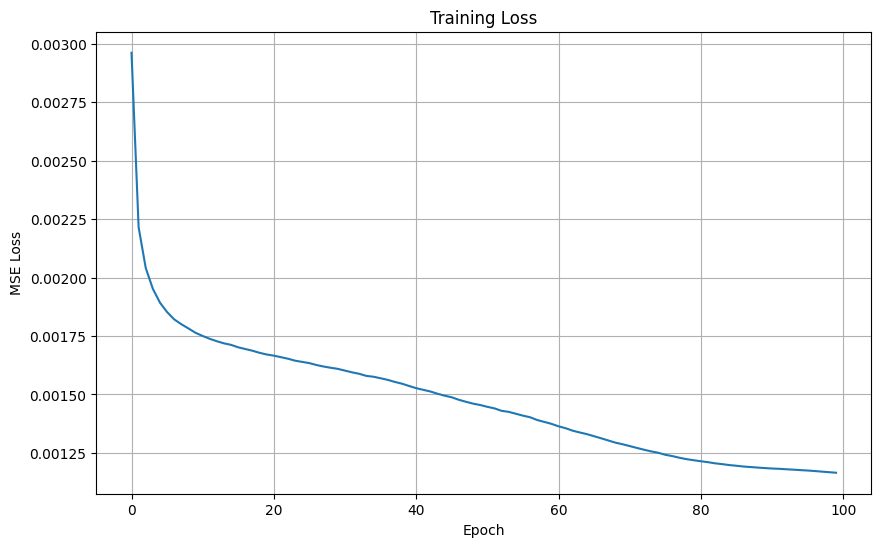

In [9]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

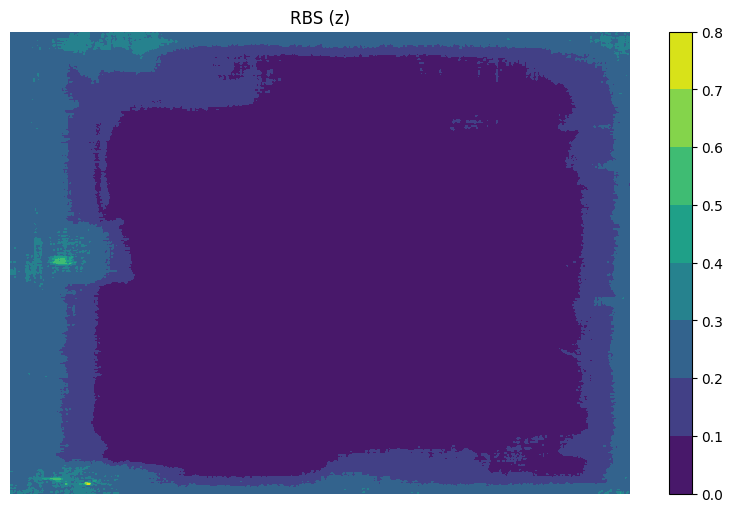

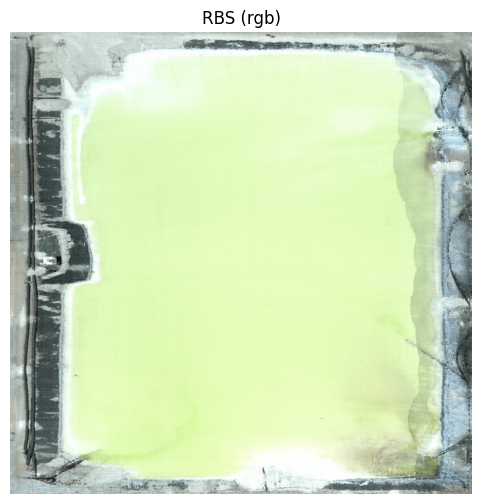

In [10]:
import numpy as np
from PIL import Image

x = np.linspace(0, 1, 1800)
y = np.linspace(0, 1, 1800)
x, y = np.meshgrid(x, y)

input = np.c_[x.ravel(), y.ravel()] 
input = torch.tensor(input, dtype=torch.float32).to(device)

output = model(input)
z = output.cpu().detach().numpy()[:,0].reshape(x.shape) 
rgb = output.cpu().detach().numpy()[:,1:].reshape(x.shape + (3,)) 


#plot z 
plt.figure(figsize=(10, 6))
plt.contourf(x, y, z, cmap='viridis')
plt.colorbar()
plt.title('RBS (z)')
plt.axis('off')
#plt.savefig(f'RBS_z.png', bbox_inches='tight', dpi=300)
plt.show()

# Plot de la superficie rgb
plt.figure(figsize=(10, 6))
plt.imshow(rgb, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
plt.title(f'RBS (rgb)'), 
plt.axis('off')
#plt.savefig(f'RBS_rbg.png', bbox_inches='tight', dpi=300)
plt.show()

In [11]:
z_save = z * 255
z_image = Image.fromarray(z_save.astype(np.uint8))
z_image.save(f'data/{PROJECT_NAME}/{POOL_NAME}_z.png')

rgb_save = rgb * 255
rgb_image = Image.fromarray(rgb_save.astype(np.uint8))
rgb_image.save(f'data/{PROJECT_NAME}/{POOL_NAME}_rgb.png')

# por poza 
# nombre de la poza
# fecha
# altura 
# frecuencia
# lat, log
# x_min, x_max
# y_min, y_max
# z_min, z_max
# nivel de agua z_water - Defecto valor para cuando no hay agua valor -inf
# img -> rgb y altura


